In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"agrsparsh12","key":"f742abd58f6278cb6c1cba5525c8273b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d agrsparsh12/mini-image-net


Dataset URL: https://www.kaggle.com/datasets/agrsparsh12/mini-image-net
License(s): other
100% 3.86G/3.87G [00:55<00:00, 125MB/s] 
100% 3.87G/3.87G [00:57<00:00, 72.7MB/s]


In [ ]:
!unzip -qq mini-image-net.zip -d mini-image-net_train


In [ ]:
!kaggle datasets download -d agrsparsh12/mini-image-net-val

Dataset URL: https://www.kaggle.com/datasets/agrsparsh12/mini-image-net-val
License(s): other
100% 1.05G/1.05G [00:11<00:00, 139MB/s]
100% 1.05G/1.05G [00:11<00:00, 97.2MB/s]


In [ ]:
!unzip -qq mini-image-net-val.zip -d mini-image-net_val

In [ ]:
!kaggle datasets download -d agrsparsh12/mini-image-net-test

Dataset URL: https://www.kaggle.com/datasets/agrsparsh12/mini-image-net-test
License(s): other
 99% 1.36G/1.37G [00:11<00:00, 132MB/s] 
100% 1.37G/1.37G [00:11<00:00, 127MB/s]


In [ ]:
!unzip -qq mini-image-net-test.zip -d mini-image-net_test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
import os
import cv2
import numpy as np
import multiprocessing as mp

def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    without any data augmentation and resizes images to 32x32.
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (42, 42)  # Resize to 42x42
            )
            datax.append(image)
            datay.append(alphabet_directory_name + '_' + character + '_0')  # Single label without augmentation
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time.
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(base_directory + '/' + directory + '/', directory))
               for directory in os.listdir(base_directory)]
    pool.close()

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay


In [ ]:
%%time
trainx, trainy = read_images('mini-image-net_train')

CPU times: user 885 ms, sys: 756 ms, total: 1.64 s
Wall time: 2min 6s


In [ ]:
%%time
valx, valy = read_images('mini-image-net_val')

CPU times: user 230 ms, sys: 206 ms, total: 436 ms
Wall time: 33.2 s


In [ ]:
%%time
testx, testy = read_images('mini-image-net_test')

CPU times: user 307 ms, sys: 237 ms, total: 544 ms
Wall time: 43.1 s


In [ ]:
trainx.shape, trainy.shape, valx.shape, valy.shape, testx.shape, testy.shape

((38400, 42, 42, 3),
 (38400,),
 (9600, 42, 42, 3),
 (9600,),
 (12000, 42, 42, 3),
 (12000,))

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [ ]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

torch.Size([8, 10, 3, 42, 42])

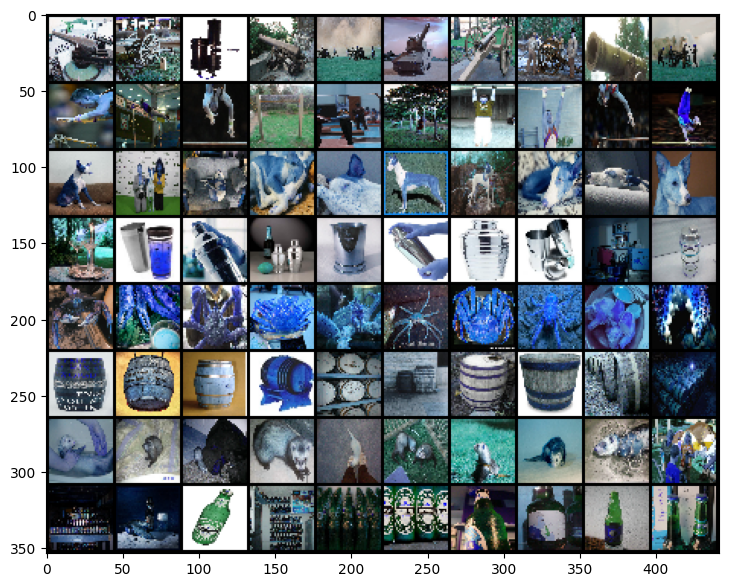

In [ ]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
sample_example['images']= sample_example['images']/255.0
display_sample(sample_example['images'])
sample_example['images'].shape

In [ ]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):               #this is where the model optimisation techniques will come in
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )

  return ProtoNet(encoder)

In [ ]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]

    #target indices are 0 ... n_way-1
    #target inds refer to the true label
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()

    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1) #computation of cluster prototypes
    z_query = z[n_way*n_support:]

    #Bregman divergences (done in line with Jake Snell's paper)
    dists_1 = euclidean_dist(z_query, z_proto)
    dists_2 = mahalanobis_dist(z_query, z_proto)
    dists_3 = kullback_igner(z_query, z_proto)
    dists_4 = itakuru_saito(z_query, z_proto)

    #compute probabilities
    log_p_y = F.log_softmax(-dists_1, dim=1).view(n_way, n_query, -1) #euclidean distance
    log_p_y_1 = F.log_softmax(-dists_2, dim=1).view(n_way, n_query, -1) #mahalanobis distance
    log_p_y_2 = F.log_softmax(-dists_3, dim=1).view(n_way, n_query, -1) #kull-back igner distance
    log_p_y_3 = F.log_softmax(-dists_4, dim=1).view(n_way, n_query, -1) #itakuru saito distance

    loss_val = -log_p_y_3.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y_3.max(2) #predicted labels                         [negative softmax log loss]
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean() #calculation of accuracy

    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat, 'query_labels':target_inds.squeeze() #returns true query labels
        }

In [ ]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [ ]:
def mahalanobis_dist(x,y):
  covariance = torch.cov(y.type(torch.float64).T)

  # Compute inverse of covariance matrix
  cov_Inv = torch.linalg.pinv(covariance).repeat(y.size(0),1,1).type(torch.float) # add ".type(torch.float)" for cnielly's code

  x = x.unsqueeze(0)
  y = y.unsqueeze(1)

  n = x.size(1)
  m = y.size(1)
  d = x.size(2)
  N = y.size(0)
  assert d == y.size(2)

  x = x.unsqueeze(2).expand(N, n, m, d)
  y = y.unsqueeze(1).expand(N, n, m, d)

  # Compute Mahalanobis distances
  d = ((x-y).squeeze() @ cov_Inv @ torch.transpose((x-y).squeeze(), -2,-1))

  return torch.transpose(torch.diagonal(d, 0,1,2), -2, -1)

In [ ]:
def kullback_igner(x,y):
  x = x / torch.transpose((x.sum(1).expand(x.shape[1], x.shape[0])), 0, 1)
  y = y / torch.transpose((y.sum(1).expand(y.shape[1], y.shape[0])), 0, 1)

  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  # Since log (0) is negative infinity, we add a small value to avoid it
  eps = 0.01

  return (x * torch.log((x+eps) / (y+eps))).sum(2) * 100

In [ ]:
def itakuru_saito(x,y):
  x = x / torch.transpose((x.sum(1).expand(x.shape[1], x.shape[0])), 0, 1)
  y = y / torch.transpose((y.sum(1).expand(y.shape[1], y.shape[0])), 0, 1)

  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  # Since log (0) is negative infinity, we add a small value to avoid it
  eps = 0.01

  return (((x+eps) / (y+eps)) - torch.log((x+eps) / (y+eps)) - 1).sum(2)

In [ ]:
from tqdm.notebook import tqdm, trange

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
def train(model, optimizer, train_x, train_y, val_x, val_y, n_way, val_n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []
  precision_list_train = []
  recall_list_train = []
  f1_score_list_train = []
  confusion_matrix_list_train = []

  precision_list_val = []
  recall_list_val = []
  f1_score_list_val = []
  confusion_matrix_list_val = []

  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0
    all_true_labels_train = []
    all_pred_labels_train = []

    #Training
    for episode in trange(epoch_size, desc="Epoch {:d} train".format(epoch+1), leave=False):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)


      running_loss += output['loss']
      running_acc += output['acc']

      true_labels = output['query_labels'].view(-1).cpu().numpy()
      pred_labels = output['y_hat'].view(-1).cpu().numpy()

   # Convert accumulated labels to numpy arrays for metric calculations

      all_true_labels_train.extend(true_labels)
      all_pred_labels_train.extend(pred_labels)

      loss.backward()
      optimizer.step()

    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    all_true_labels_train = np.array(all_true_labels_train)
    all_pred_labels_train = np.array(all_pred_labels_train)

    # Calculate precision, recall, F1 score, and confusion matrix
    precision_train = precision_score(all_true_labels_train, all_pred_labels_train, average='weighted')
    recall_train = recall_score(all_true_labels_train, all_pred_labels_train, average='weighted')
    f1_train = f1_score(all_true_labels_train, all_pred_labels_train, average='weighted')
    conf_matrix_train = confusion_matrix(all_true_labels_train, all_pred_labels_train)


    precision_list_train.append(precision_train)
    recall_list_train.append(recall_train)
    f1_score_list_train.append(f1_train)
    confusion_matrix_list_train.append(conf_matrix_train)
    print('Epoch {:d} -- Training Loss: {:.4f} Train Acc: {:.4f}'.format(epoch+1, epoch_loss, epoch_acc)) #prints loss values, accuracy and the respective epoch



    #Validation Set
    val_loss, val_acc, val_true_labels, val_pred_labels = validate(model, val_x, val_y, val_n_way, n_support, n_query)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Compute precision, recall, F1 score, and confusion matrix for validation set
    precision_val = precision_score(val_true_labels, val_pred_labels, average='weighted')
    recall_val = recall_score(val_true_labels, val_pred_labels, average='weighted')
    f1_val = f1_score(val_true_labels, val_pred_labels, average='weighted')
    conf_matrix_val = confusion_matrix(val_true_labels, val_pred_labels)

    precision_list_val.append(precision_val)
    recall_list_val.append(recall_val)
    f1_score_list_val.append(f1_val)
    confusion_matrix_list_val.append(conf_matrix_val)

    print('Epoch {:d} -- Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch+1, val_loss, val_acc))


    epoch += 1
    scheduler.step()

  return train_loss_list, train_acc_list, val_loss_list, val_acc_list


In [ ]:
def validate(model, val_x, val_y, val_n_way, n_support, n_query):
    """
    Runs validation on the validation set
    Args:
        model
        val_x (np.array): images of validation set
        val_y(np.array): labels of validation set
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    episode_size = 100  # Number of validation episodes
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for episode in range(episode_size):
            sample = extract_sample(n_way, n_support, n_query, val_x, val_y)
            _, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            true_labels = output['query_labels'].view(-1).cpu().numpy()
            pred_labels = output['y_hat'].view(-1).cpu().numpy()

            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)



    val_loss = running_loss / episode_size
    val_acc = running_acc / episode_size

    # Convert the lists to numpy arrays for metric calculations
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)

    # Calculate precision, recall, F1 score, and confusion matrix
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')
    conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

    model.train()  # Set back to training mode
    return val_loss, val_acc, all_true_labels, all_pred_labels

In [ ]:
%%time
import torch.optim as optim


model = load_protonet_conv(
    x_dim=(3,42,42),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

n_way = 10
n_support = 5
n_query = 15 #(new change as per the paper - made on 18 Oct)
val_n_way= 5

train_x = trainx
train_y = trainy
val_x = valx
val_y = valy

max_epoch = 10
epoch_size = 2000

train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(model, optimizer, train_x, train_y, val_x, val_y, n_way, val_n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 3 -- Training Loss: 0.9566 Train Acc: 0.6570
Epoch 3 -- Val Loss: 1.6806 Val Acc: 0.4313


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Training Loss: 0.8594 Train Acc: 0.6897
Epoch 4 -- Val Loss: 1.7228 Val Acc: 0.4297


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Training Loss: 0.8252 Train Acc: 0.7009
Epoch 5 -- Val Loss: 1.7334 Val Acc: 0.4215


Epoch 6 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 6 -- Training Loss: 0.7881 Train Acc: 0.7143
Epoch 6 -- Val Loss: 1.7510 Val Acc: 0.4233


Epoch 7 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 7 -- Training Loss: 0.7801 Train Acc: 0.7165
Epoch 7 -- Val Loss: 1.7611 Val Acc: 0.4137


Epoch 8 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 8 -- Training Loss: 0.7631 Train Acc: 0.7226
Epoch 8 -- Val Loss: 1.7460 Val Acc: 0.4177


Epoch 9 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 9 -- Training Loss: 0.7609 Train Acc: 0.7236
Epoch 9 -- Val Loss: 1.7440 Val Acc: 0.4217


Epoch 10 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 -- Training Loss: 0.7601 Train Acc: 0.7239
Epoch 10 -- Val Loss: 1.7293 Val Acc: 0.4276
CPU times: user 1h 25min 48s, sys: 5min 17s, total: 1h 31min 5s
Wall time: 1h 31min 50s


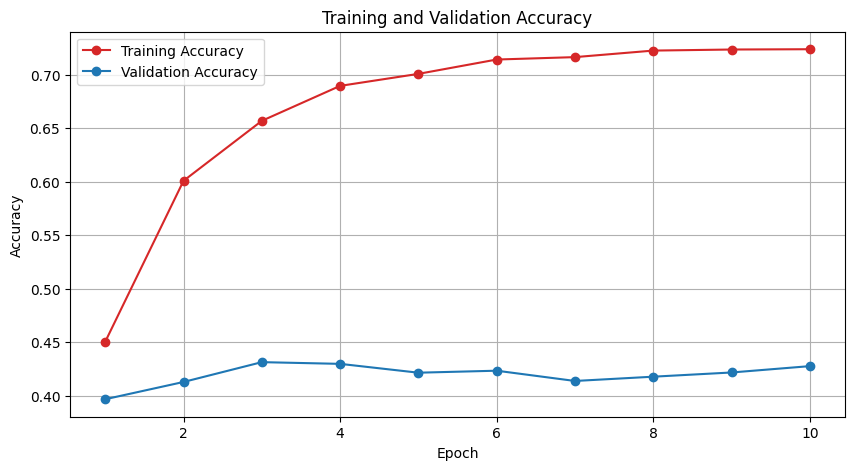

In [ ]:
import matplotlib.pyplot as plt

# Example epoch list (replace with your actual epoch count)
epoch_list = [1,2,3,4,5,6,7,8,9,10]

# Create a figure and axis object
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(epoch_list, train_acc_list, 'o-', color='tab:red', label='Training Accuracy')

# Plot validation accuracy
plt.plot(epoch_list, val_acc_list, 'o-', color='tab:blue', label='Validation Accuracy')

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.grid()
plt.show()


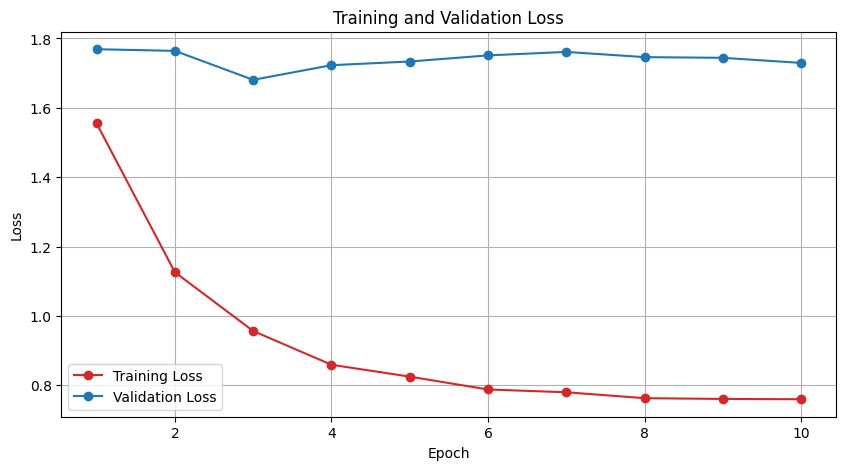

In [ ]:
import matplotlib.pyplot as plt

# Example epoch list (replace with your actual epoch count)
epoch_list = [1,2,3,4,5,6,7,8,9,10]

# Create a figure and axis object
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(epoch_list, train_loss_list, 'o-', color='tab:red', label='Training Loss')

# Plot validation accuracy
plt.plot(epoch_list, val_loss_list, 'o-', color='tab:blue', label='Validation Loss')

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add a legend
plt.legend()

# Show the plot
plt.grid()
plt.show()


In [ ]:
model_save=model.state_dict()
print(model_save)


OrderedDict([('encoder.0.0.weight', tensor([[[[-1.1601, -0.8368,  0.3953],
          [-1.4391, -1.5675, -0.7202],
          [-0.2727,  0.4580,  1.1538]],

         [[ 0.0314,  0.3866,  0.8689],
          [-0.2512, -0.2363,  0.2238],
          [-0.2130,  0.5103,  0.7557]],

         [[ 0.0249,  0.0263, -0.0244],
          [-0.1928, -0.1062, -0.0706],
          [-0.3917,  0.0485,  0.0274]]],


        [[[-0.0064,  0.2991,  0.4976],
          [ 0.0095,  0.3923,  0.3611],
          [-0.6840, -0.7494, -0.4970]],

         [[ 0.4542,  0.8280,  0.4680],
          [ 0.4959,  1.3392,  0.8620],
          [ 0.1588,  0.5583,  0.2952]],

         [[-0.3013, -0.2784, -0.3220],
          [-0.1682,  0.2421, -0.1010],
          [-0.2702,  0.1500, -0.0585]]],


        [[[-0.5428, -0.6629,  0.0885],
          [ 0.3155, -0.0962,  0.1416],
          [-0.0893,  0.3824,  0.5487]],

         [[-0.4283, -0.8783,  0.0620],
          [-0.0027, -0.0330,  0.3451],
          [ 0.3502,  0.2073,  0.2597]],

        

In [ ]:
print(model)
#4 convolutional blocks, output will be a flattened tensor that will be used to compute prototypes
#this will give us the blockwise description of each of it - explaining about convolutional layers, batch normalisation, ReLu, and MaxPool layers
#any modifications to the model architecture will come up over here

ProtoNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), st

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")
#4 blocks in the overall architecture - 4 CNN layers likely, there are other activation layers also (they don't have any learnable parameters)

Layer: encoder.0.0.weight | Size: torch.Size([64, 3, 3, 3]) | Requires Grad: True
Layer: encoder.0.0.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.0.1.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.0.1.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.1.0.weight | Size: torch.Size([64, 64, 3, 3]) | Requires Grad: True
Layer: encoder.1.0.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.1.1.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.1.1.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.2.0.weight | Size: torch.Size([64, 64, 3, 3]) | Requires Grad: True
Layer: encoder.2.0.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.2.1.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.2.1.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: encoder.3.0.weight | Size: torch.Size([64, 64, 3, 3]) | Requires Grad: True
Layer: encoder.3.0.bias 

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  all_true_labels = []
  all_pred_labels = []
  accuracies=[]
  for episode in trange(test_episode, desc='Testing'):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)

    running_loss += output['loss']
    running_acc += output['acc']

    true_labels = output['query_labels'].view(-1).cpu().numpy()  # Ground truth labels
    pred_labels = output['y_hat'].view(-1).cpu().numpy()  # Predicted labels

    all_true_labels.extend(true_labels)
    all_pred_labels.extend(pred_labels)
    accuracies.append(output['acc'])  # Collect individual episode accuracies


  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode

  # Convert the lists to numpy arrays for metric calculations
  all_true_labels = np.array(all_true_labels)
  all_pred_labels = np.array(all_pred_labels)

  # Calculate precision, recall, F1 score, and confusion matrix
  precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
  recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
  f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')
  conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))


  return avg_loss, accuracies

In [ ]:
#TESTING
n_way_list = [3, 5, 20]
n_support_list = [1,5]
n_query = 15
test_episode = 600 #(new change - made on 18 Oct)

test_x = testx
test_y = testy
results = {}
for n_way in n_way_list:
    for n_support in n_support_list:
        print(f"Testing with n_way={n_way}, n_support={n_support}")
        accuracies = test(model, test_x, test_y, n_way, n_support, n_query, test_episode)
        results[(n_way, n_support)] = accuracies

Testing with n_way=3, n_support=1


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Test results -- Loss: 1.3773 Acc: 0.5660
Testing with n_way=3, n_support=5


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Test results -- Loss: 0.6717 Acc: 0.7254
Testing with n_way=5, n_support=1


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Test results -- Loss: 2.0157 Acc: 0.4350
Testing with n_way=5, n_support=5


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Test results -- Loss: 1.0591 Acc: 0.6018
Testing with n_way=20, n_support=1


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Test results -- Loss: 3.7685 Acc: 0.1958
Testing with n_way=20, n_support=5


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Test results -- Loss: 2.2171 Acc: 0.3368


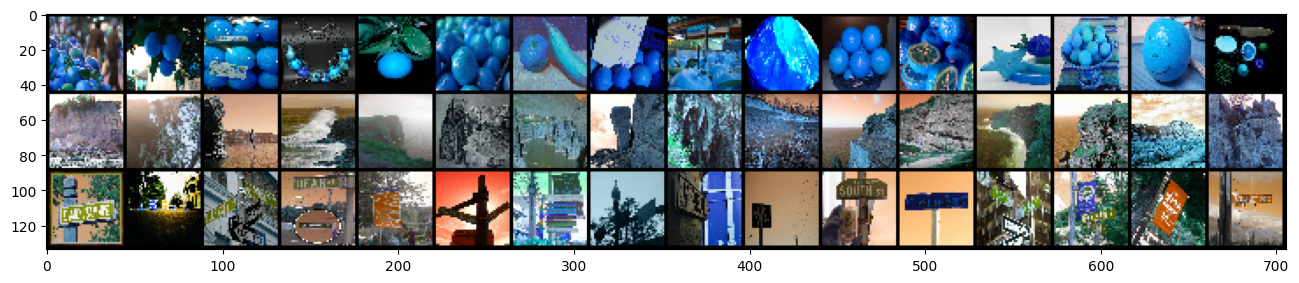

In [ ]:
#displaying the sample set through which the model will parse through
my_sample = extract_sample(n_way_list[0], n_support_list[0], n_query, test_x, test_y)
my_sample['images']=my_sample['images'] / 255.0
display_sample(my_sample['images'])

In [ ]:
my_loss, my_output = model.set_forward_loss(my_sample)
print(my_loss)
my_output

tensor(0.6554, device='cuda:0', grad_fn=<NegBackward0>)


{'loss': 0.6554234027862549,
 'acc': 0.8666666746139526,
 'y_hat': tensor([[0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2]], device='cuda:0'),
 'query_labels': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], device='cuda:0')}